# Import Libraries

In [19]:
from src.capstone.evaluation import Evaluator
from src.capstone.cbf import CBF
from src.capstone.settings import Env

from bound_propagation.parallel import Parallel
from bound_propagation.bivariate import Mul
from bound_propagation.reshape import Select
from bound_propagation.polynomial import UnivariateMonomial
from bound_propagation.linear import FixedLinear
from bound_propagation.activation import Sin

import numpy as np
import gymnasium as gym
from gymnasium.spaces import Box
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

# Gym wrapper for dynamics

In [2]:
class PendulumNoise(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(low=np.array([float('-inf'), -8]),
                                     high=np.array([float('inf'), 8]),
                                     dtype=np.float32)
        
        self.dt = 0.01
        
    def step(self, action):
        action = np.array([action], dtype=np.float32)  # cannot be scalar like used in Discrete gym envs
        
        th, thdot = self.env.unwrapped.state
        _, _, _, truncated, _ = self.env.step(action)
        
        u = np.clip(action, -self.env.unwrapped.max_torque, 
                    self.env.unwrapped.max_torque)[0]
        
        newthdot = thdot + np.sin(th) * self.dt + u * self.dt + np.random.normal(0., 0.025)
        newth = th + thdot * self.dt + np.random.normal(0., 0.005)
        
        self.env.unwrapped.state = np.array([newth, newthdot], dtype=np.float32)
        
        return self.env.unwrapped.state, 0., False, truncated, {}
    
    def reset(self, seed: list[float, float] = None):
        # allow the user to set the initial state directly, otherwise random state
        self.env.reset()
        
        if seed is not None:
            self.env.unwrapped.state = np.array(seed, dtype=np.float32)
        return self.env.unwrapped.state, {}

# NNDM

We assume the dynamics are known, to be able to directly compare our results to the paper. The NNDM outputs the EXPECTED next state (Gaussian noise term disappears).

In [3]:
class NNDM(nn.Sequential):
    # input [theta, theta_dot, u]
    
    def __init__(self):
        self.dt = 0.01
        
        super(NNDM, self).__init__(
            # outputs [theta{k+1}, theta{k}, theta_dot{k}, u{k}, sin() of previous 3 elements]
            Parallel(
                FixedLinear(
                    torch.tensor([
                        [1, self.dt, 0.]
                    ])
                ),
                
                Parallel(
                    FixedLinear(
                        torch.tensor([
                            [1., 0., 0.],
                            [0., 1., 0.],
                            [0., 0., 1.]
                        ])
                    ),
                    Sin(),
                )
            ),
            
            # now calculate theta_dot{k+1}, output [theta{k+1}, theta_dot{k+1}]
            Parallel(
                Select(0),
                FixedLinear(
                    torch.tensor([
                        [0., 0., 1., self.dt, self.dt, 0., 0.]
                    ])
                )
            )
        )

In [4]:
nndm = NNDM()

# Agent

In [5]:
class Agent(nn.Module):
    # dummy agent of linear form a = c1 * s1 + c2 * s2 + c3, always outputs 0.
    
    def __init__(self):
        super(Agent, self).__init__()
        
        self.layer = nn.Linear(2, 1)
        
        # dummy output of u=0
        self.layer.weight = nn.Parameter(torch.tensor([[0., 0.]]))
        self.layer.bias = nn.Parameter(torch.tensor([0.]))
    
    def forward(self, x):
        return self.layer(x)
    
    def select_action(self, x, exploration=False):
        if exploration:
            raise ValueError('This model is not implemented for exploration')
        else:
            return self.forward(x)

In [6]:
policy = Agent()

# Env settings

$$h(x) = 1 - \frac{6^2}{\pi^2} \left(\theta^2 + \dot{\theta}^2 + \frac{2}{\sqrt{3}} \theta \dot{\theta} \right)$$

In [7]:
class Pendulum(Env):
    def __init__(self):
        env = gym.make('Pendulum-v1')
        env.spec.max_episode_steps = 100

        self.is_discrete = False
        
        self.settings = {
            'noise': [],
            'max_frames': 100
        }
        
        # h as defined in the paper
        self.h_function = nn.Sequential(
            Parallel(
                UnivariateMonomial([(0, 2)]),
                UnivariateMonomial([(1, 2)]),
                Mul(Select([0]), Select([1]))
            ),
            FixedLinear(
                torch.tensor([[1., 1., 2./(3.**0.5)]])
            ),
            FixedLinear(
                torch.tensor([[-36 / 3.1415**2]]),
                torch.tensor([1.])
            )
        )
        
        self.h_ids = [0, 1]
        self.std = [0.005, 0.025]
        self.env = PendulumNoise(env)

In [8]:
env = Pendulum()

# CBF

$$\nabla^2 h = \begin{bmatrix}
\frac{\partial^2{h}}{\partial{\theta}^2} & \frac{\partial^2{h}}{\partial{\theta}\partial{\dot{\theta}}}\\ 
\frac{\partial^2{h}}{\partial{\dot{\theta}}\partial{\theta}} & \frac{\partial^2{h}}{\partial{\dot{\theta}}^2}
\end{bmatrix}

= \begin{bmatrix}
-2 \cdot \frac{6^2}{\pi^2} & -\frac{2}{\sqrt{3}} \cdot \frac{6^2}{\pi^2}\\ 
-\frac{2}{\sqrt{3}} \cdot \frac{6^2}{\pi^2} & -2 \cdot \frac{6^2}{\pi^2}
\end{bmatrix}

= -2 \cdot \frac{6^2}{\pi^2} 
\begin{bmatrix}
1 & \frac{1}{\sqrt{3}}\\ 
\frac{1}{\sqrt{3}} & 1
\end{bmatrix}$$

Since the Hessian is a 2x2 matrix, the matrix 2-norm will be equal to the largest singular value. In this case we get

$$\nabla^2 h^T \ \nabla^2 h = 
4\cdot \frac{6^4}{\pi^4} 
\begin{bmatrix}
\frac{4}{3} & \frac{2}{\sqrt{3}}\\ 
\frac{2}{\sqrt{3}} & \frac{4}{3}
\end{bmatrix}

= \begin{bmatrix}
\frac{6912}{\pi^4} & \frac{3456 \sqrt{3}}{\pi^4}\\ 
\frac{3456 \sqrt{3}}{\pi^4} & \frac{6912}{\pi^4}
\end{bmatrix}$$

$$det(\nabla^2 h^T \ \nabla^2 h - \sigma I) =
\left( \frac{6912}{\pi^4} - \sigma \right)^2 - \frac{3456 \sqrt{3}}{\pi^4} ^ 2 = 0$$

$$\sigma_{\pm} = \frac{6912}{\pi^4} \pm \frac{3456 \sqrt{3}}{\pi^4}$$

So, finally we get (this output has been verified online to be correct):
$$\lambda_{max} = \sqrt{\sigma_+} = \frac{1}{\pi^2} \sqrt{6912 + 3456 \sqrt{3}}$$

$$cov(d) = \begin{bmatrix}
\sigma_1^2 & 0\\ 
0 & \sigma_2^2
\end{bmatrix}

= \begin{bmatrix}
0.005^2 & 0\\ 
0 & 0.025^2
\end{bmatrix}$$

$$tr(cov(d)) = 0.005^2 + 0.025^2 = 0.00065 = \frac{13}{20 000}$$

Now everything comes together
$$\psi = \frac{\lambda_{max}}{2} tr(cov(d))$$
$$\alpha = 1 - \psi = 1 - \frac{13}{40 000\pi^2} \sqrt{6912 + 3456 \sqrt{3}}$$

In [9]:
lambda_max = (1/3.1415**2) * (6912 + 3456 * 3 ** 0.5) ** 0.5
tr_cov = sum(noise ** 2 for noise in env.std)

alpha = 1 - (lambda_max / 2) * tr_cov
print(f'Alpha is {round(alpha, 3)}')

Alpha is 0.996


In [10]:
# what to do with delta? 
cbf = CBF(env, nndm, policy,
          alpha=[alpha],
          delta=[0.],
          no_action_partitions=2,
          no_noise_partitions=2,
          stochastic=False)

# Evaluation

In [11]:
evaluator = Evaluator(env, cbf)
f, h = evaluator.mc_simulate(policy, 100, seed=[0.1, 0.])

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
f

[149,
 74,
 189,
 84,
 90,
 131,
 135,
 70,
 132,
 98,
 44,
 141,
 94,
 122,
 99,
 130,
 140,
 195,
 174,
 130,
 80,
 77,
 136,
 66,
 180,
 174,
 200,
 81,
 132,
 124,
 89,
 105,
 43,
 87,
 73,
 76,
 105,
 80,
 48,
 153,
 111,
 164,
 150,
 41,
 155,
 71,
 84,
 48,
 95,
 123,
 107,
 103,
 93,
 168,
 43,
 140,
 124,
 118,
 69,
 79,
 92,
 137,
 149,
 156,
 196,
 64,
 52,
 102,
 93,
 133,
 165,
 118,
 134,
 96,
 198,
 149,
 160,
 60]

In [18]:
def interpolate_color(value):
    "colab with chatgpt"
    if value <= 0.5:
        # Interpolate from blue to white
        red = int(255 * (value / 0.5))
        green = int(255 * (value / 0.5))
        blue = 255
    else:
        # Interpolate from white to red
        red = 255
        green = int(255 * ((1 - value) / 0.5))
        blue = int(255 * ((1 - value) / 0.5))
    return np.array([red/255, green/255, blue/255])

# Test the function
for i in np.linspace(0, 1, 10):
    print(f"{i}: {interpolate_color(i)}")

0.0: [0. 0. 1.]
0.1111111111111111: [0.21960784 0.21960784 1.        ]
0.2222222222222222: [0.44313725 0.44313725 1.        ]
0.3333333333333333: [0.66666667 0.66666667 1.        ]
0.4444444444444444: [0.88627451 0.88627451 1.        ]
0.5555555555555556: [1.         0.88627451 0.88627451]
0.6666666666666666: [1.         0.66666667 0.66666667]
0.7777777777777777: [1.         0.44313725 0.44313725]
0.8888888888888888: [1.         0.21960784 0.21960784]
1.0: [1. 0. 0.]


  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 1/107 [00:12<21:49, 12.35s/it]

current point: (-0.6, 0.20000000000000018), fraction: 0.9627329192546584


  0%|          | 0/500 [00:00<?, ?it/s]

  2%|▏         | 2/107 [00:53<51:37, 29.50s/it]

current point: (-0.6, 0.30000000000000004), fraction: 0.8185745140388769


  0%|          | 0/500 [00:00<?, ?it/s]

  3%|▎         | 3/107 [01:37<1:01:59, 35.76s/it]

current point: (-0.6, 0.40000000000000013), fraction: 0.6359102244389028


  0%|          | 0/500 [00:00<?, ?it/s]

  4%|▎         | 4/107 [02:05<56:33, 32.95s/it]  

current point: (-0.6, 0.5), fraction: 0.6015037593984962


  0%|          | 0/500 [00:00<?, ?it/s]

  5%|▍         | 5/107 [02:09<38:00, 22.35s/it]

current point: (-0.5, 0.0), fraction: 0.9859437751004017


  0%|          | 0/500 [00:00<?, ?it/s]

  6%|▌         | 6/107 [02:22<32:35, 19.36s/it]

current point: (-0.5, 0.10000000000000009), fraction: 0.9380165289256198


  0%|          | 0/500 [00:00<?, ?it/s]

  7%|▋         | 7/107 [02:46<34:53, 20.93s/it]

current point: (-0.5, 0.20000000000000018), fraction: 0.7654867256637168


  0%|          | 0/500 [00:00<?, ?it/s]

  7%|▋         | 8/107 [03:18<40:19, 24.44s/it]

current point: (-0.5, 0.30000000000000004), fraction: 0.5945273631840796


  0%|          | 0/500 [00:00<?, ?it/s]

  8%|▊         | 9/107 [03:56<46:49, 28.67s/it]

current point: (-0.5, 0.40000000000000013), fraction: 0.40591397849462363


  0%|          | 0/500 [00:00<?, ?it/s]

  9%|▉         | 10/107 [04:33<50:17, 31.11s/it]

current point: (-0.5, 0.5), fraction: 0.4406779661016949


  0%|          | 0/500 [00:00<?, ?it/s]

 10%|█         | 11/107 [04:54<44:47, 27.99s/it]

current point: (-0.5, 0.6000000000000001), fraction: 0.7801932367149759


  0%|          | 0/500 [00:00<?, ?it/s]

 11%|█         | 12/107 [04:59<33:24, 21.10s/it]

current point: (-0.3999999999999999, -0.09999999999999998), fraction: 0.9839034205231388


  0%|          | 0/500 [00:00<?, ?it/s]

 12%|█▏        | 13/107 [05:13<29:22, 18.75s/it]

current point: (-0.3999999999999999, 0.0), fraction: 0.9176954732510288


  0%|          | 0/500 [00:00<?, ?it/s]

 13%|█▎        | 14/107 [05:34<30:26, 19.64s/it]

current point: (-0.3999999999999999, 0.10000000000000009), fraction: 0.811816192560175


  0%|          | 0/500 [00:00<?, ?it/s]

 14%|█▍        | 15/107 [06:05<35:20, 23.05s/it]

current point: (-0.3999999999999999, 0.20000000000000018), fraction: 0.6313253012048192


  0%|          | 0/500 [00:00<?, ?it/s]

 15%|█▍        | 16/107 [06:43<41:48, 27.56s/it]

current point: (-0.3999999999999999, 0.30000000000000004), fraction: 0.4479166666666667


  0%|          | 0/500 [00:00<?, ?it/s]

 16%|█▌        | 17/107 [07:35<52:05, 34.72s/it]

current point: (-0.3999999999999999, 0.40000000000000013), fraction: 0.358974358974359


  0%|          | 0/500 [00:00<?, ?it/s]

 17%|█▋        | 18/107 [08:13<52:58, 35.71s/it]

current point: (-0.3999999999999999, 0.5), fraction: 0.5631868131868132


  0%|          | 0/500 [00:00<?, ?it/s]

 18%|█▊        | 19/107 [08:34<45:57, 31.34s/it]

current point: (-0.3999999999999999, 0.6000000000000001), fraction: 0.783410138248848


  0%|          | 0/500 [00:00<?, ?it/s]

 19%|█▊        | 20/107 [08:41<34:56, 24.09s/it]

current point: (-0.29999999999999993, -0.19999999999999996), fraction: 0.9778672032193159


  0%|          | 0/500 [00:00<?, ?it/s]

 20%|█▉        | 21/107 [08:56<30:32, 21.31s/it]

current point: (-0.29999999999999993, -0.09999999999999998), fraction: 0.9417879417879418


  0%|          | 0/500 [00:00<?, ?it/s]

 21%|██        | 22/107 [09:21<31:49, 22.47s/it]

current point: (-0.29999999999999993, 0.0), fraction: 0.8070175438596491


  0%|          | 0/500 [00:00<?, ?it/s]

 21%|██▏       | 23/107 [09:55<36:14, 25.89s/it]

current point: (-0.29999999999999993, 0.10000000000000009), fraction: 0.6167076167076168


  0%|          | 0/500 [00:00<?, ?it/s]

 22%|██▏       | 24/107 [10:34<41:12, 29.79s/it]

current point: (-0.29999999999999993, 0.20000000000000018), fraction: 0.3935309973045822


  0%|          | 0/500 [00:00<?, ?it/s]

 23%|██▎       | 25/107 [11:15<45:17, 33.14s/it]

current point: (-0.29999999999999993, 0.30000000000000004), fraction: 0.3409090909090909


  0%|          | 0/500 [00:00<?, ?it/s]

 24%|██▍       | 26/107 [11:51<46:09, 34.19s/it]

current point: (-0.29999999999999993, 0.40000000000000013), fraction: 0.4837837837837838


  0%|          | 0/500 [00:00<?, ?it/s]

 25%|██▌       | 27/107 [12:19<42:53, 32.17s/it]

current point: (-0.29999999999999993, 0.5), fraction: 0.6753554502369669


  0%|          | 0/500 [00:00<?, ?it/s]

 26%|██▌       | 28/107 [12:32<34:51, 26.48s/it]

current point: (-0.29999999999999993, 0.6000000000000001), fraction: 0.8877118644067796


  0%|          | 0/500 [00:00<?, ?it/s]

 27%|██▋       | 29/107 [12:38<26:29, 20.38s/it]

current point: (-0.19999999999999996, -0.29999999999999993), fraction: 0.9859437751004017


  0%|          | 0/500 [00:00<?, ?it/s]

 28%|██▊       | 30/107 [12:52<23:48, 18.55s/it]

current point: (-0.19999999999999996, -0.19999999999999996), fraction: 0.9075975359342916


  0%|          | 0/500 [00:00<?, ?it/s]

 29%|██▉       | 31/107 [13:14<24:42, 19.50s/it]

current point: (-0.19999999999999996, -0.09999999999999998), fraction: 0.8181818181818182


  0%|          | 0/500 [00:00<?, ?it/s]

 30%|██▉       | 32/107 [13:46<28:52, 23.11s/it]

current point: (-0.19999999999999996, 0.0), fraction: 0.6394230769230769


  0%|          | 0/500 [00:00<?, ?it/s]

 31%|███       | 33/107 [14:24<34:03, 27.62s/it]

current point: (-0.19999999999999996, 0.10000000000000009), fraction: 0.444141689373297


  0%|          | 0/500 [00:00<?, ?it/s]

 32%|███▏      | 34/107 [15:06<38:56, 32.01s/it]

current point: (-0.19999999999999996, 0.20000000000000018), fraction: 0.37341772151898733


  0%|          | 0/500 [00:00<?, ?it/s]

 33%|███▎      | 35/107 [15:45<40:51, 34.04s/it]

current point: (-0.19999999999999996, 0.30000000000000004), fraction: 0.46742209631728043


  0%|          | 0/500 [00:00<?, ?it/s]

 34%|███▎      | 36/107 [16:15<38:46, 32.77s/it]

current point: (-0.19999999999999996, 0.40000000000000013), fraction: 0.6619047619047619


  0%|          | 0/500 [00:00<?, ?it/s]

 35%|███▍      | 37/107 [16:36<34:22, 29.47s/it]

current point: (-0.19999999999999996, 0.5), fraction: 0.8051948051948052


  0%|          | 0/500 [00:00<?, ?it/s]

 36%|███▌      | 38/107 [16:42<25:31, 22.19s/it]

current point: (-0.19999999999999996, 0.6000000000000001), fraction: 0.9718875502008032


  0%|          | 0/500 [00:00<?, ?it/s]

 36%|███▋      | 39/107 [16:48<19:39, 17.35s/it]

current point: (-0.09999999999999998, -0.3999999999999999), fraction: 0.9879518072289156


  0%|          | 0/500 [00:00<?, ?it/s]

 37%|███▋      | 40/107 [17:03<18:36, 16.66s/it]

current point: (-0.09999999999999998, -0.29999999999999993), fraction: 0.9142857142857143


  0%|          | 0/500 [00:00<?, ?it/s]

 38%|███▊      | 41/107 [17:27<20:45, 18.87s/it]

current point: (-0.09999999999999998, -0.19999999999999996), fraction: 0.8120950323974082


  0%|          | 0/500 [00:00<?, ?it/s]

 39%|███▉      | 42/107 [18:01<25:20, 23.39s/it]

current point: (-0.09999999999999998, -0.09999999999999998), fraction: 0.5957446808510638


  0%|          | 0/500 [00:00<?, ?it/s]

 40%|████      | 43/107 [18:42<30:35, 28.67s/it]

current point: (-0.09999999999999998, 0.0), fraction: 0.48404255319148937


  0%|          | 0/500 [00:00<?, ?it/s]

 41%|████      | 44/107 [19:28<35:42, 34.01s/it]

current point: (-0.09999999999999998, 0.10000000000000009), fraction: 0.32653061224489793


  0%|          | 0/500 [00:00<?, ?it/s]

 42%|████▏     | 45/107 [20:12<38:12, 36.97s/it]

current point: (-0.09999999999999998, 0.20000000000000018), fraction: 0.43380281690140843


  0%|          | 0/500 [00:00<?, ?it/s]

 43%|████▎     | 46/107 [20:47<36:55, 36.32s/it]

current point: (-0.09999999999999998, 0.30000000000000004), fraction: 0.6078431372549019


  0%|          | 0/500 [00:00<?, ?it/s]

 44%|████▍     | 47/107 [21:08<31:37, 31.63s/it]

current point: (-0.09999999999999998, 0.40000000000000013), fraction: 0.8305084745762712


  0%|          | 0/500 [00:00<?, ?it/s]

 45%|████▍     | 48/107 [21:19<25:05, 25.51s/it]

current point: (-0.09999999999999998, 0.5), fraction: 0.9227642276422764


  0%|          | 0/500 [00:00<?, ?it/s]

 46%|████▌     | 49/107 [21:22<18:12, 18.84s/it]

current point: (0.0, -0.5), fraction: 0.9919191919191919


  0%|          | 0/500 [00:00<?, ?it/s]

 47%|████▋     | 50/107 [21:36<16:23, 17.25s/it]

current point: (0.0, -0.3999999999999999), fraction: 0.911340206185567


  0%|          | 0/500 [00:00<?, ?it/s]

 48%|████▊     | 51/107 [21:56<17:01, 18.24s/it]

current point: (0.0, -0.29999999999999993), fraction: 0.825531914893617


  0%|          | 0/500 [00:00<?, ?it/s]

 49%|████▊     | 52/107 [22:29<20:44, 22.63s/it]

current point: (0.0, -0.19999999999999996), fraction: 0.5947242206235012


  0%|          | 0/500 [00:00<?, ?it/s]

 50%|████▉     | 53/107 [23:08<24:46, 27.52s/it]

current point: (0.0, -0.09999999999999998), fraction: 0.4444444444444444


  0%|          | 0/500 [00:00<?, ?it/s]

 50%|█████     | 54/107 [23:51<28:30, 32.26s/it]

current point: (0.0, 0.0), fraction: 0.2909090909090909


  0%|          | 0/500 [00:00<?, ?it/s]

 51%|█████▏    | 55/107 [24:30<29:35, 34.14s/it]

current point: (0.0, 0.10000000000000009), fraction: 0.4131578947368421


  0%|          | 0/500 [00:00<?, ?it/s]

 52%|█████▏    | 56/107 [25:01<28:15, 33.24s/it]

current point: (0.0, 0.20000000000000018), fraction: 0.6576354679802956


  0%|          | 0/500 [00:00<?, ?it/s]

 53%|█████▎    | 57/107 [25:24<25:03, 30.06s/it]

current point: (0.0, 0.30000000000000004), fraction: 0.8


  0%|          | 0/500 [00:00<?, ?it/s]

 54%|█████▍    | 58/107 [25:38<20:41, 25.33s/it]

current point: (0.0, 0.40000000000000013), fraction: 0.9104166666666667


  0%|          | 0/500 [00:00<?, ?it/s]

 55%|█████▌    | 59/107 [25:42<15:09, 18.95s/it]

current point: (0.0, 0.5), fraction: 0.9919191919191919


  0%|          | 0/500 [00:00<?, ?it/s]

 56%|█████▌    | 60/107 [25:53<12:54, 16.48s/it]

current point: (0.10000000000000009, -0.5), fraction: 0.9421487603305785


  0%|          | 0/500 [00:00<?, ?it/s]

 57%|█████▋    | 61/107 [26:14<13:40, 17.84s/it]

current point: (0.10000000000000009, -0.3999999999999999), fraction: 0.8236559139784946


  0%|          | 0/500 [00:00<?, ?it/s]

 58%|█████▊    | 62/107 [26:45<16:30, 22.01s/it]

current point: (0.10000000000000009, -0.29999999999999993), fraction: 0.6706730769230769


  0%|          | 0/500 [00:00<?, ?it/s]

 59%|█████▉    | 63/107 [27:23<19:39, 26.81s/it]

current point: (0.10000000000000009, -0.19999999999999996), fraction: 0.4603174603174603


  0%|          | 0/500 [00:00<?, ?it/s]

 60%|█████▉    | 64/107 [28:07<22:49, 31.84s/it]

current point: (0.10000000000000009, -0.09999999999999998), fraction: 0.3474320241691843


  0%|          | 0/500 [00:00<?, ?it/s]

 61%|██████    | 65/107 [28:48<24:11, 34.57s/it]

current point: (0.10000000000000009, 0.0), fraction: 0.3788300835654596


  0%|          | 0/500 [00:00<?, ?it/s]

 62%|██████▏   | 66/107 [29:21<23:20, 34.16s/it]

current point: (0.10000000000000009, 0.10000000000000009), fraction: 0.6274509803921569


  0%|          | 0/500 [00:00<?, ?it/s]

 63%|██████▎   | 67/107 [29:43<20:22, 30.57s/it]

current point: (0.10000000000000009, 0.20000000000000018), fraction: 0.8261802575107297


  0%|          | 0/500 [00:00<?, ?it/s]

 64%|██████▎   | 68/107 [29:57<16:38, 25.60s/it]

current point: (0.10000000000000009, 0.30000000000000004), fraction: 0.9262295081967213


  0%|          | 0/500 [00:00<?, ?it/s]

 64%|██████▍   | 69/107 [30:03<12:26, 19.64s/it]

current point: (0.10000000000000009, 0.40000000000000013), fraction: 0.9919839679358717


  0%|          | 0/500 [00:00<?, ?it/s]

 65%|██████▌   | 70/107 [30:08<09:27, 15.33s/it]

current point: (0.20000000000000018, -0.6), fraction: 0.9675456389452333


  0%|          | 0/500 [00:00<?, ?it/s]

 66%|██████▋   | 71/107 [30:27<09:47, 16.31s/it]

current point: (0.20000000000000018, -0.5), fraction: 0.8405172413793104


  0%|          | 0/500 [00:00<?, ?it/s]

 67%|██████▋   | 72/107 [30:58<12:10, 20.87s/it]

current point: (0.20000000000000018, -0.3999999999999999), fraction: 0.6374407582938388


  0%|          | 0/500 [00:00<?, ?it/s]

 68%|██████▊   | 73/107 [31:38<14:58, 26.42s/it]

current point: (0.20000000000000018, -0.29999999999999993), fraction: 0.4490861618798956


  0%|          | 0/500 [00:00<?, ?it/s]

 69%|██████▉   | 74/107 [32:21<17:18, 31.48s/it]

current point: (0.20000000000000018, -0.19999999999999996), fraction: 0.3673469387755102


  0%|          | 0/500 [00:00<?, ?it/s]

 70%|███████   | 75/107 [33:00<17:55, 33.60s/it]

current point: (0.20000000000000018, -0.09999999999999998), fraction: 0.5013192612137203


  0%|          | 0/500 [00:00<?, ?it/s]

 71%|███████   | 76/107 [33:33<17:20, 33.56s/it]

current point: (0.20000000000000018, 0.0), fraction: 0.624390243902439


  0%|          | 0/500 [00:00<?, ?it/s]

 72%|███████▏  | 77/107 [33:57<15:22, 30.76s/it]

current point: (0.20000000000000018, 0.10000000000000009), fraction: 0.7672413793103449


  0%|          | 0/500 [00:00<?, ?it/s]

 73%|███████▎  | 78/107 [34:12<12:27, 25.79s/it]

current point: (0.20000000000000018, 0.20000000000000018), fraction: 0.9205702647657841


  0%|          | 0/500 [00:00<?, ?it/s]

 74%|███████▍  | 79/107 [34:18<09:20, 20.00s/it]

current point: (0.20000000000000018, 0.30000000000000004), fraction: 0.9818913480885312


  0%|          | 0/500 [00:00<?, ?it/s]

 75%|███████▍  | 80/107 [34:31<08:06, 18.02s/it]

current point: (0.30000000000000004, -0.6), fraction: 0.8928571428571429


  0%|          | 0/500 [00:00<?, ?it/s]

 76%|███████▌  | 81/107 [35:01<09:19, 21.52s/it]

current point: (0.30000000000000004, -0.5), fraction: 0.65807962529274


  0%|          | 0/500 [00:00<?, ?it/s]

 77%|███████▋  | 82/107 [35:42<11:21, 27.28s/it]

current point: (0.30000000000000004, -0.3999999999999999), fraction: 0.4723756906077348


  0%|          | 0/500 [00:00<?, ?it/s]

 78%|███████▊  | 83/107 [36:25<12:48, 32.04s/it]

current point: (0.30000000000000004, -0.29999999999999993), fraction: 0.3465909090909091


  0%|          | 0/500 [00:00<?, ?it/s]

 79%|███████▊  | 84/107 [37:08<13:34, 35.43s/it]

current point: (0.30000000000000004, -0.19999999999999996), fraction: 0.38858695652173914


  0%|          | 0/500 [00:00<?, ?it/s]

 79%|███████▉  | 85/107 [37:45<13:05, 35.70s/it]

current point: (0.30000000000000004, -0.09999999999999998), fraction: 0.5693430656934306


  0%|          | 0/500 [00:00<?, ?it/s]

 80%|████████  | 86/107 [38:09<11:20, 32.39s/it]

current point: (0.30000000000000004, 0.0), fraction: 0.8061002178649237


  0%|          | 0/500 [00:00<?, ?it/s]

 81%|████████▏ | 87/107 [38:25<09:04, 27.24s/it]

current point: (0.30000000000000004, 0.10000000000000009), fraction: 0.9281314168377823


  0%|          | 0/500 [00:00<?, ?it/s]

 82%|████████▏ | 88/107 [38:32<06:43, 21.26s/it]

current point: (0.30000000000000004, 0.20000000000000018), fraction: 0.9738955823293173


  0%|          | 0/500 [00:00<?, ?it/s]

 83%|████████▎ | 89/107 [38:53<06:23, 21.29s/it]

current point: (0.40000000000000013, -0.6), fraction: 0.8091954022988506


  0%|          | 0/500 [00:00<?, ?it/s]

 84%|████████▍ | 90/107 [39:30<07:21, 25.99s/it]

current point: (0.40000000000000013, -0.5), fraction: 0.5289473684210526


  0%|          | 0/500 [00:00<?, ?it/s]

 85%|████████▌ | 91/107 [40:15<08:26, 31.64s/it]

current point: (0.40000000000000013, -0.3999999999999999), fraction: 0.35798816568047337


  0%|          | 0/500 [00:00<?, ?it/s]

 86%|████████▌ | 92/107 [40:57<08:40, 34.68s/it]

current point: (0.40000000000000013, -0.29999999999999993), fraction: 0.44919786096256686


  0%|          | 0/500 [00:00<?, ?it/s]

 87%|████████▋ | 93/107 [41:30<07:59, 34.28s/it]

current point: (0.40000000000000013, -0.19999999999999996), fraction: 0.6548463356973995


  0%|          | 0/500 [00:00<?, ?it/s]

 88%|████████▊ | 94/107 [41:54<06:46, 31.27s/it]

current point: (0.40000000000000013, -0.09999999999999998), fraction: 0.8


  0%|          | 0/500 [00:00<?, ?it/s]

 89%|████████▉ | 95/107 [42:10<05:18, 26.52s/it]

current point: (0.40000000000000013, 0.0), fraction: 0.9309623430962343


  0%|          | 0/500 [00:00<?, ?it/s]

 90%|████████▉ | 96/107 [42:16<03:44, 20.42s/it]

current point: (0.40000000000000013, 0.10000000000000009), fraction: 0.9879275653923542


  0%|          | 0/500 [00:00<?, ?it/s]

 91%|█████████ | 97/107 [42:36<03:24, 20.43s/it]

current point: (0.5, -0.6), fraction: 0.7806004618937644


  0%|          | 0/500 [00:00<?, ?it/s]

 92%|█████████▏| 98/107 [43:18<04:02, 26.91s/it]

current point: (0.5, -0.5), fraction: 0.4518950437317784


  0%|          | 0/500 [00:00<?, ?it/s]

 93%|█████████▎| 99/107 [43:59<04:09, 31.13s/it]

current point: (0.5, -0.3999999999999999), fraction: 0.4792243767313019


  0%|          | 0/500 [00:00<?, ?it/s]

 93%|█████████▎| 100/107 [44:34<03:45, 32.27s/it]

current point: (0.5, -0.29999999999999993), fraction: 0.6330049261083743


  0%|          | 0/500 [00:00<?, ?it/s]

 94%|█████████▍| 101/107 [44:56<02:54, 29.11s/it]

current point: (0.5, -0.19999999999999996), fraction: 0.8516129032258064


  0%|          | 0/500 [00:00<?, ?it/s]

 95%|█████████▌| 102/107 [45:10<02:02, 24.45s/it]

current point: (0.5, -0.09999999999999998), fraction: 0.9230769230769231


  0%|          | 0/500 [00:00<?, ?it/s]

 96%|█████████▋| 103/107 [45:13<01:13, 18.27s/it]

current point: (0.5, 0.0), fraction: 0.9859719438877755


  0%|          | 0/500 [00:00<?, ?it/s]

 97%|█████████▋| 104/107 [45:47<01:08, 22.98s/it]

current point: (0.6000000000000001, -0.5), fraction: 0.6030534351145038


  0%|          | 0/500 [00:00<?, ?it/s]

 98%|█████████▊| 105/107 [46:21<00:52, 26.02s/it]

current point: (0.6000000000000001, -0.3999999999999999), fraction: 0.6070588235294118


  0%|          | 0/500 [00:00<?, ?it/s]

 99%|█████████▉| 106/107 [46:41<00:24, 24.47s/it]

current point: (0.6000000000000001, -0.29999999999999993), fraction: 0.8658008658008658


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 107/107 [46:50<00:00, 26.27s/it]

current point: (0.6000000000000001, -0.19999999999999996), fraction: 0.9409368635437881


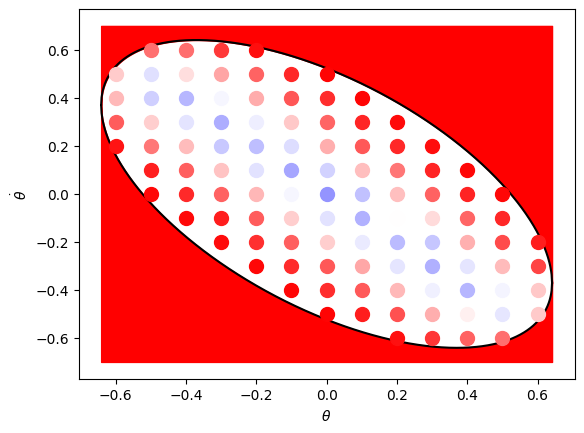

In [31]:
def state_space_plot():
    sims_pp = 500
    x_list = np.linspace(-(3/2)**0.5 * np.pi/6 , (3/2)**0.5 * np.pi/6 , 1001)
    upper_elipse = [-x/3**0.5 + (-2/3 * x**2 + np.pi**2 / 36)**0.5 for x in x_list
                    if -(3/2)**0.5 * np.pi/6 <= x <= (3/2)**0.5 * np.pi/6]
    lower_elipse = [-x/3**0.5 - (-2/3 * x**2 + np.pi**2 / 36)**0.5 for x in x_list
                    if -(3/2)**0.5 * np.pi/6 <= x <= (3/2)**0.5 * np.pi/6]

    grid_points = [(x, y) for x in np.linspace(-1, 1, 21) 
                   for y in np.linspace(-1, 1, 21) 
                   if env.h_function(torch.tensor([x, y], dtype=torch.float32)) >= 0]
    
    # ToDo implement MC simulate on each gridpoint
    
    fig, ax = plt.subplots()
    ax.plot(x_list, upper_elipse, color='black')
    ax.plot(x_list, lower_elipse, color='black')
    ax.fill_between(x_list, 0.7, upper_elipse, color='red', alpha=1)
    ax.fill_between(x_list, lower_elipse, -0.7, color='red', alpha=1)
    plt.xlabel(r'${\theta}$')
    plt.ylabel(r'$\dot{\theta}$')
    
    for point in tqdm(grid_points):
        state = [point[0], point[1]]
        f, h = evaluator.mc_simulate(policy, sims_pp, seed=state)
        lst = [1 if x <= 100 else 0 for x in f]
        # fraction unsafe is amount of agents failed before 100 frames / num_agents
        try:           
            frac = sum(lst) / len(lst)
            frac_color = interpolate_color(frac)
            print("current point: {}, fraction: {}".format(point, frac))
            ax.plot(point[0], point[1], marker='o', color=frac_color, markersize=10)
        except ZeroDivisionError:
            continue
    plt.savefig("state_space_plot.png")
    plt.show()

state_space_plot()